<a href="https://colab.research.google.com/github/chirag1701/Cora_citation_gnn/blob/main/Cora_gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision


In [2]:
!pip install torch torchvision torchaudio


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 638.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.6 MB/s eta 0:00:00


In [4]:
import torch_geometric

In [5]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
dataset = Planetoid(root = 'data/Planetoid', name = 'Cora', transform = NormalizeFeatures())

Processing...
Done!


In [6]:
print(f"Number of graphs : {len(dataset)}")
print(f'Number of features : {dataset.num_features}')
print(f'Number of classes : {dataset.num_classes}')
print(100*"*")

Number of graphs : 1
Number of features : 1433
Number of classes : 7
****************************************************************************************************


In [7]:
data = dataset[0]
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [8]:
print(f"Number of nodes : {data.num_nodes}")
print(f"Number of edges : {data.num_edges}")

Number of nodes : 2708
Number of edges : 10556


In [9]:
print(f'Number of training nodes: {data.train_mask.sum()}')   # sum of all True values give us the total number of training nodes

Number of training nodes: 140


In [10]:
print(f"Training node label rate : {(data.train_mask.sum()/data.num_nodes):.2f}")

Training node label rate : 0.05


In [11]:
print(f"Undirected data : {data.is_undirected()}")

Undirected data : True


In [12]:
data.x.shape  # (Number of nodes, features)

torch.Size([2708, 1433])

In [13]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [14]:
len(data.test_mask)==data.num_nodes

True

In [15]:
data.test_mask


tensor([False, False, False,  ...,  True,  True,  True])

In [16]:
data.edge_index.t() # individual node connection information

tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        ...,
        [ 598, 2707],
        [1473, 2707],
        [2706, 2707]])

In [17]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


In [53]:
class GCN(torch.nn.Module):
   def __init__(self, hidden_channels):
    super(GCN,self).__init__()
    torch.manual_seed(41)
    self.conv1 = GCNConv(dataset.num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)
    self.conv3 = GCNConv(hidden_channels, hidden_channels)
    self.out = Linear(hidden_channels, dataset.num_classes)
   def forward(self,x, edge_index) :  # no batch_index needed since we have only 1 graph
    x = self.conv1( x ,edge_index)
    x = x.relu()
    x = self.conv2( x , edge_index)
    x = x.relu()
    x = self.conv3( x, edge_index)
    x = x.relu()  # Introduces non linearity at each step
    x = F.dropout(x, p = 0.4, training = self.training)
    x = self.out(x) # applies the final linear layer
    x = F.softmax(x, dim = 1)
    return x
model = GCN(hidden_channels = 32)
print(model)

GCN(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (out): Linear(in_features=32, out_features=7, bias=True)
)


In [54]:
model = GCN(hidden_channels = 32)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)
learning_rate = 0.01
decay = 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = decay)
criterion_loss = torch.nn.CrossEntropyLoss()

In [55]:
def train():
  model.train()
  optimizer.zero_grad()
  output = model(data.x, data.edge_index)
  loss = criterion_loss(output[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

def test():
  model.eval()
  output = model(data.x, data.edge_index)
  pred = output.argmax(dim = 1)
  test_correct = pred[data.test_mask] == data.y[data.test_mask] # it will be an array
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
  return test_acc

losses = []
for epoch in range(0, 1001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch}, Loss: {loss:.4f}')


Epoch: 0, Loss: 1.9459
Epoch: 100, Loss: 1.1894
Epoch: 200, Loss: 1.1774
Epoch: 300, Loss: 1.1785
Epoch: 400, Loss: 1.1834
Epoch: 500, Loss: 1.1727
Epoch: 600, Loss: 1.1757
Epoch: 700, Loss: 1.1721
Epoch: 800, Loss: 1.1883
Epoch: 900, Loss: 1.1730
Epoch: 1000, Loss: 1.1769


<Axes: >

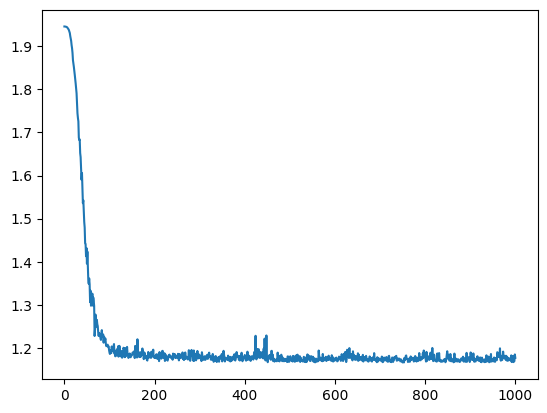

In [56]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
sns.lineplot(x = loss_indices, y= losses_float)

In [57]:
test_acc = test()
print(test_acc)

0.703


#**VISUALISATION**

In [59]:
!pip install moviepy

In [61]:
# prompt: write code to make gif of epochs tsne using moviepy

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
import numpy as np

def visualize(epoch, loss):
  model.eval()
  z = model(data.x, data.edge_index)
  z = TSNE(n_components=2).fit_transform(z.cpu().detach().numpy())
  plt.figure(figsize=(10, 10))
  plt.scatter(z[:, 0], z[:, 1], c=data.y.cpu(), cmap="tab10")
  plt.title(f"Epoch: {epoch}, Loss: {loss:.4f}")
  plt.savefig(f"epoch_{epoch}.png")
  plt.close()
frames = []
for epoch in range(0, 101):
    loss = train()
    if epoch % 10 == 0:
      visualize(epoch, loss)
      frames.append(f"epoch_{epoch}.png")

clip = ImageSequenceClip(frames, fps=2)
clip.write_gif("tsne_animation.gif", fps=2)
clip


MoviePy - Building file tsne_animation.gif with imageio.


In [ ]:
# prompt: write code to make gif of epochs tsne using moviepy

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
import numpy as np

def visualize(epoch, loss):
  model.eval()
  z = model(data.x, data.edge_index)
  z = TSNE(n_components=2).fit_transform(z.cpu().detach().numpy())
  plt.figure(figsize=(10, 10))
  plt.scatter(z[:, 0], z[:, 1], c=data.y.cpu(), cmap="tab10")
  plt.title(f"Epoch: {epoch}, Loss: {loss:.4f}")
  plt.savefig(f"epoch_{epoch}.png")
  plt.close()
frames = []
for epoch in range(0, 101):
    loss = train()
    if epoch % 10 == 0:
      visualize(epoch, loss)
      frames.append(f"epoch_{epoch}.png")

clip = ImageSequenceClip(frames, fps=2)
clip.write_gif("tsne_animation.gif", fps=2)
clip


MoviePy - Building file tsne_animation.gif with imageio.


In [70]:
# prompt: write code to make gif of epochs tsne using moviepy

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip
import numpy as np

def visualize(epoch, loss):
  model.eval()
  z = model(data.x, data.edge_index)
  z = TSNE(n_components=2).fit_transform(z.cpu().detach().numpy())
  plt.figure(figsize=(10, 10))
  plt.scatter(z[:, 0], z[:, 1], c=data.y.cpu(), cmap="tab10")
  plt.title(f"Epoch: {epoch}, Loss: {loss:.4f}")
  plt.savefig(f"epoch_{epoch}.png")
  plt.close()
frames = []
for epoch in range(0, 1001):
    loss = train()
    if epoch % 100 == 0:
      visualize(epoch, loss)
      frames.append(f"epoch_{epoch}.png")

clip = ImageSequenceClip(frames, fps=3)
clip.write_gif("tsne_animation.gif", fps=3)
clip


MoviePy - Building file tsne_animation.gif with imageio.


In [71]:
!ls -l tsne_animation.gif


-rw-r--r-- 1 root root 535708 Aug 12 11:15 tsne_animation.gif


In [72]:
from google.colab import files
files.download('tsne_animation.gif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

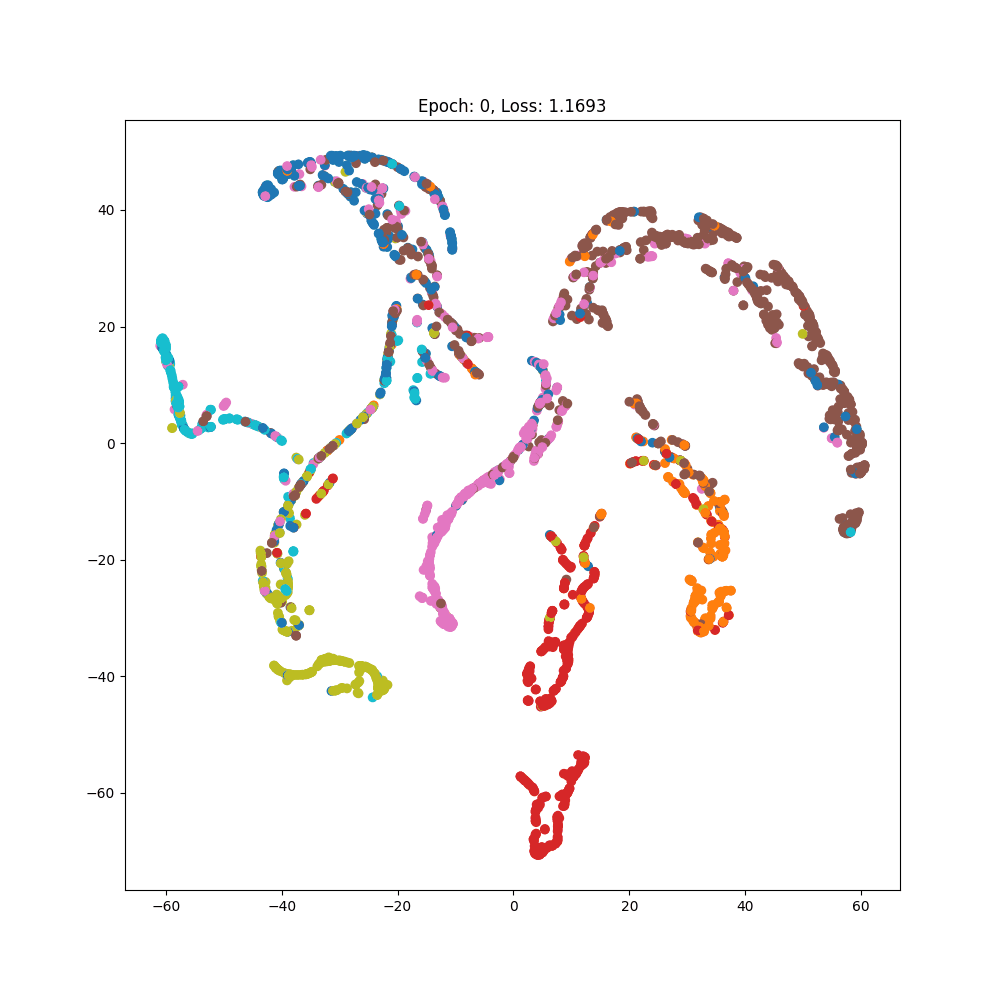

In [73]:
from IPython.display import Image
Image(filename='tsne_animation.gif')